In [40]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, transpile
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit.circuit import Parameter, ParameterVector
import numpy as np
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.extensions import HamiltonianGate
from qiskit.opflow import X, Y, Z, I
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from functools import partial
from scipy.optimize import minimize as opt
from time import time

def create_hamiltonian(N): #crea l'hamiltoniana generale di ising dati i campi e n di qubits
    for q in range(N): #questo for crea i termini Hz,Hx,Hzz insieme H=gzz*Hz-gx*Hx-gz*Hz
        if q==0:
            opz=Z
            opx=X
            opzz=Z
        else:
            opz=I
            opx=I
            opzz=I
        if q==N-1:
            opzz=Z
        for i in range(1,N):
            if i==q:
                opz=opz^Z
                opx=opx^X
            else:
                opz=opz^I
                opx=opx^I
            if i==q or i==q+1:
                opzz=opzz^Z
            else:
                opzz=opzz^I
        if q==0:
            Hz=opz
            Hx=opx
            Hzz=opzz
        else:
            Hz=Hz+opz
            Hx=Hx+opx
            Hzz=Hzz+opzz
    return Hz,Hx,Hzz

def create_graph(N):
    g=[]
    for i in range(N):
        g.append((i,i+1))
        if i==N-2:
            g.append((N-1,0))
            break
    return g

def create_parameterized_circuit(N,p): #crea il circuito parametrico
    gamma=ParameterVector('gamma',p)
    beta=ParameterVector('beta',p)
    qr=QuantumRegister(N, 'q')
    qc=QuantumCircuit(qr)
    qc.h(qr[0:N])
    g=create_graph(N)
    for i in range(p):
        for edge in g: #cost layer, evolution with gzz*Hzz
            qc.cx(edge[0],edge[1])
            qc.rz(-2*gzz*gamma[i],edge[1])
            qc.cx(edge[0],edge[1])
        qc.rz(-2*gz*gamma[i],qr[0:N]) #cost layer, evolution with -gz*Hz
        qc.rx(-2*gx*beta[i],qr[0:N]) #mixer layer
    return qc

def expectation_value(parameters,estimator,qc,Htot): #calcola il valore dell'energia tramite l'estimator
    qc.assign_parameters(parameters,inplace=True)
    job = estimator.run(qc,Htot)
    result=job.result()
    return result.values[0]

def generate_random_parameters(p): #genera i parametri casualmente tra 0 e pi
    initial_parameters=np.empty(p) #al circuito vanno dati prima i beta in ordine e poi i gamma in ordine
    for i in range(p):
        initial_parameters[i]=np.random.uniform(0,2*np.pi)
    return initial_parameters

def compute_new_parameters(old_parameters,P): #metodo INTERP
    new_parameters=np.empty(P)
    new_parameters[0]=old_parameters[0]
    for i in range(P-1):
        new_parameters[i]=(i/(P-1))*old_parameters[i-1]+((P-1-i)/(P-1))*old_parameters[i]
    new_parameters[P-1]=old_parameters[P-2]
    return new_parameters

def optimization_via_INTERP(N,P_max):
    Hz,Hx,Hzz=create_hamiltonian(N)
    Htot=gzz*Hzz+gx*Hx+gz*Hz
    #optimizer=partial(opt,method='L-BFGS-B')
    qc=create_parameterized_circuit(N,1)
    estimator=Estimator()
    gammas=[0.1]
    betas=[0.1]
    new_parameters=betas+gammas
    start_time=time()
    Result=VQE(estimator,qc,optimizer,initial_point=new_parameters).compute_minimum_eigenvalue(Htot)
    optimized_parameters=Result.optimal_point
    step=Result.cost_function_evals
    for P in range(2,P_max+1):
        qc=create_parameterized_circuit(N,P)
        gammas=compute_new_parameters(gammas,P)
        betas=compute_new_parameters(betas,P)
        new_parameters=np.concatenate((betas,gammas))
        Result=VQE(estimator,qc,optimizer,initial_point=new_parameters).compute_minimum_eigenvalue(Htot)
        optimized_parameters=Result.optimal_point
        step=step+Result.cost_function_evals
    comput_time=time()-start_time
    return Result,comput_time,step

def find_the_GS(H):
    matrix_to_diag=H.to_matrix().real
    diag_matrix=np.linalg.eig(matrix_to_diag)
    index=np.argmin(diag_matrix[0])
    return diag_matrix[1][:,index]

def fidelity(H,QAOA_state):
    GS_real=find_the_GS(H)
    fid=np.vdot(QAOA_state,GS_real)
    return (fid.real)**2+(fid.imag)**2

In [35]:
gx=-0.5 #campo trasverso
gz=0 #campo longitudinale
gzz=-1 #coef. davanti all'interazione (-1=ferro,+1=antiferro)
N=6
p=3

In [43]:
opt_list=['NM','Powell','CG','BFGS','L-BFGS-B','TNC','COBYLA','SLSQP']

In [37]:
Hz,Hx,Hzz=create_hamiltonian(6)
Htot=gzz*Hzz+gx*Hx+gz*Hz

In [41]:
file=open('../files/Comparison_classical_optimizers_N={}_p={}.dat'.format(N,p),'w')
file.write('COMPARISON BETWEEN CLASSICAL OPTIMIZERS WITH INTERP N={} p={}\n'.format(N,p))
file.write('Opt_name     step     time     parameters     fidelity\n')
#N_step=[]
#fidelities=[]
tempo=[]
for i in opt_list:
    optimizer=partial(opt,method=i)
    result,comput_time,step=optimization_via_INTERP(N,p)
    file.write(i)
    file.write('\n')
    file.write(str(step))
    file.write('\n')
    file.write(str(comput_time))
    file.write('\n')
    #N_step.append(step)
    tempo.append(comput_time)
    np.savetxt(file,result.optimal_point)
    qc=result.optimal_circuit.assign_parameters(result.optimal_point)
    state=Statevector(qc).data
    f=fidelity(Htot,state)
    file.write(str(f))
    file.write('\n')
    #fidelities.append(f)
file.close()

/home/matteo/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method CG cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/matteo/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method CG cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/matteo/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/matteo/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


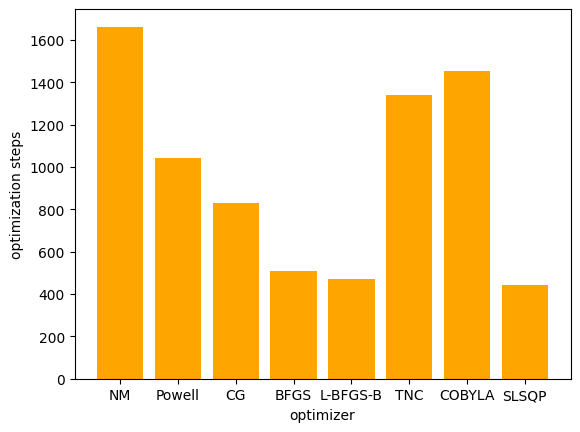

In [44]:
x=np.arange(0,len(fidelities),1)
plt.bar(x,N_step,color='orange')
plt.xticks(x,opt_list)
plt.ylabel('optimization steps')
plt.xlabel('optimizer')
plt.show()

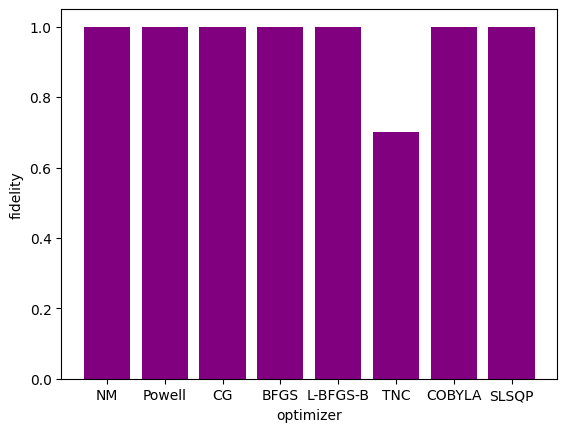

In [33]:
plt.bar(x,fidelities,color='purple')
plt.xticks(x,opt_list)
plt.ylabel('fidelity')
plt.xlabel('optimizer')
plt.show()

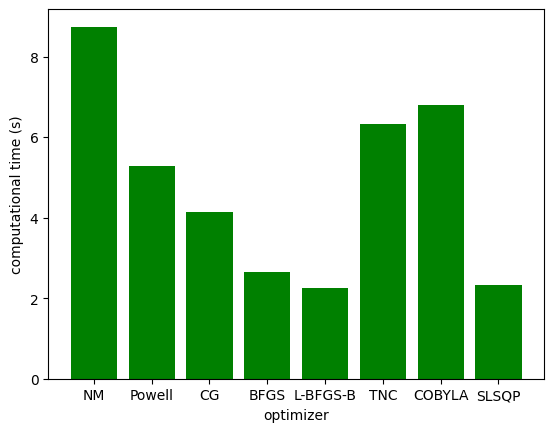

In [46]:
plt.bar(x,tempo,color='green')
plt.xticks(x,opt_list)
plt.ylabel('computational time (s)')
plt.xlabel('optimizer')
plt.show()